Detailed report saved as api_detailed_anomaly_report.txt


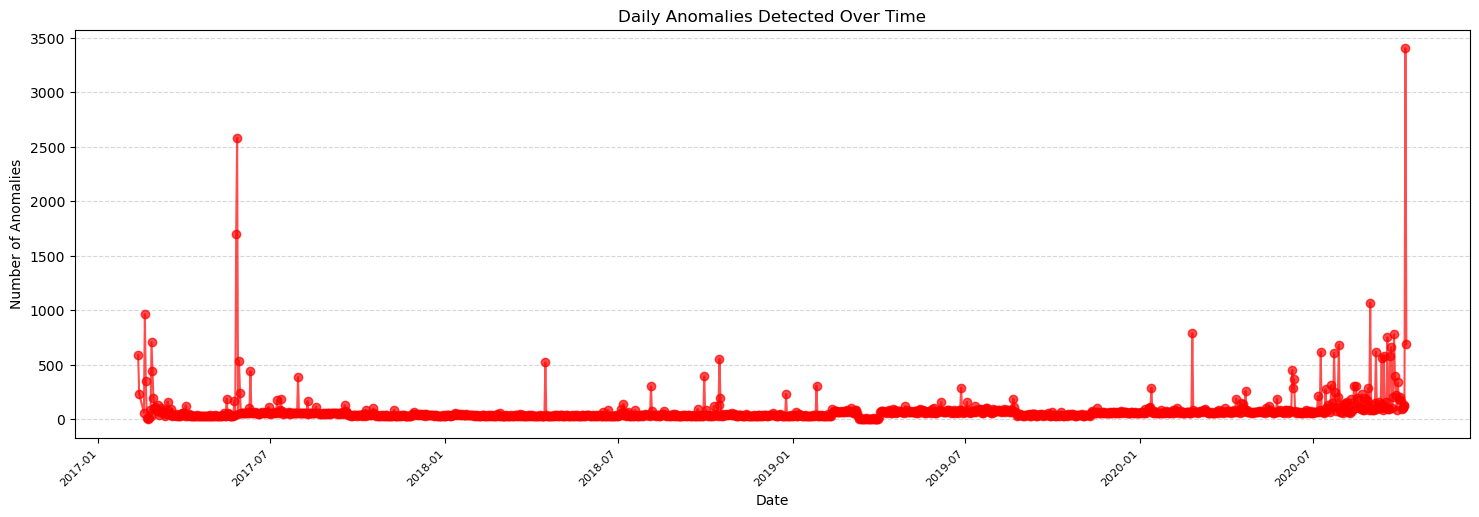

/tmp/ipykernel_3463/3064437882.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.index, y=event_counts.values, palette="viridis")


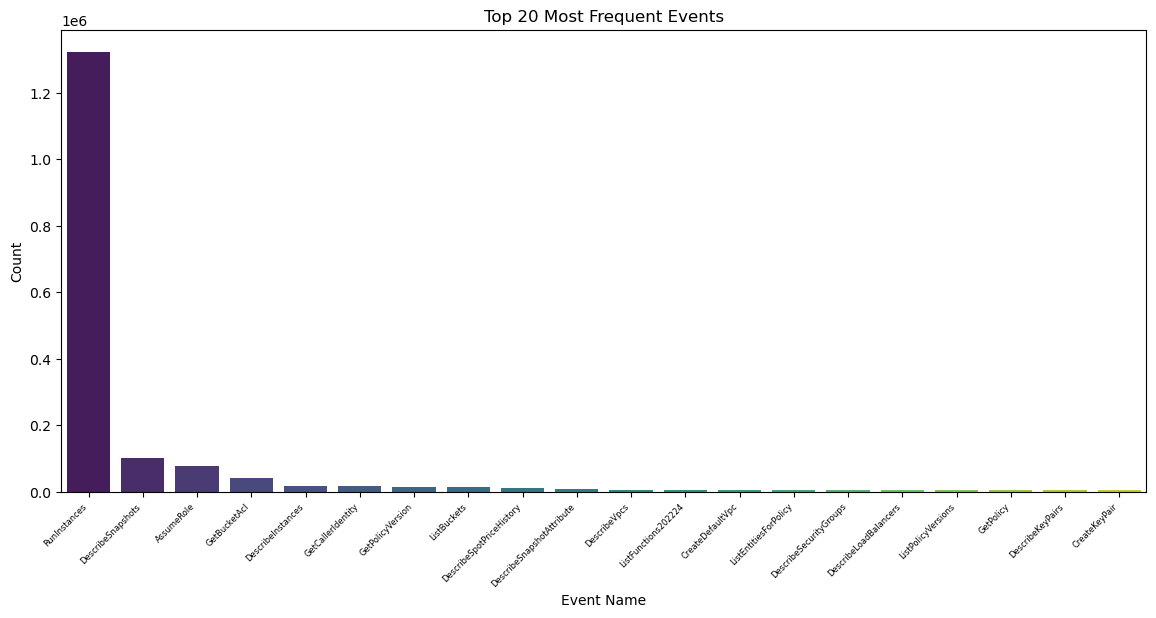

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

file_path = "cleaned_logs.csv"
df = pd.read_csv(file_path)

df["eventTime"] = pd.to_datetime(df["eventTime"], errors="coerce")

label_encoders = {}
categorical_columns = ["sourceIPAddress", "userAgent", "eventName", "eventSource", "awsRegion", "userIdentitytype", "eventType", "userIdentityaccountId", "errorCode", "requestParametersinstanceType"]
original_value_mappings = {}

def encode_column(col):
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        original_value_mappings[col] = dict(zip(le.transform(le.classes_), le.classes_))

for col in categorical_columns:
    encode_column(col)

df.fillna(0, inplace=True)

df["eventTimestamp"] = df["eventTime"].apply(lambda x: x.timestamp() if pd.notnull(x) else 0).astype(int)
df["eventDate"] = df["eventTime"].dt.date

X = df.drop(columns=["errorCode", "eventTime", "eventDate"])
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
df["is_anomaly"] = isolation_forest.fit_predict(X)
df["is_anomaly"] = df["is_anomaly"].map({1: 0, -1: 1})

def generate_detailed_report():
    anomaly_data = df[df["is_anomaly"] == 1][["eventTime", "sourceIPAddress", "eventName", "awsRegion", "errorCode"]]
    anomaly_data = anomaly_data.sort_values(by="eventTime", ascending=True)
    
    for col in categorical_columns:
        if col in anomaly_data.columns and col in label_encoders:
            anomaly_data[col] = anomaly_data[col].map(original_value_mappings[col])
    
    with open("api_detailed_anomaly_report.txt", "w") as f:
        f.write("API Detailed Anomaly Report\n")
        f.write("====================================\n\n")
        f.write("Top Anomalies Detected:\n")
        f.write(anomaly_data.to_string(index=False))
    print("Detailed report saved as api_detailed_anomaly_report.txt")

generate_detailed_report()

df["eventDate"] = pd.to_datetime(df["eventDate"])
daily_anomalies = df.groupby("eventDate")["is_anomaly"].sum()

plt.figure(figsize=(18, 6))
daily_anomalies.plot(kind='line', marker='o', color='red', alpha=0.7)
plt.title("Daily Anomalies Detected Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig("daily_anomalies.png", dpi=300, bbox_inches="tight")
plt.show()

df["decodedEventName"] = df["eventName"].map(original_value_mappings.get("eventName", {}))
event_counts = df["decodedEventName"].value_counts().head(20)
plt.figure(figsize=(14, 6))
sns.barplot(x=event_counts.index, y=event_counts.values, palette="viridis")
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.xlabel("Event Name")
plt.ylabel("Count")
plt.title("Top 20 Most Frequent Events")
plt.savefig("top_events.png", dpi=300, bbox_inches="tight")
plt.show()